# DATA PROJECT: A dive into companies, startups and bankruptcies of the Danish private sector

**TABLE OF CONTENTS**<a id='toc0_'></a>    
- [1. Project description](#toc1_)    
- [2. Imports and set magics](#toc2_) 
- [3. Read, clean and explore data](#toc3_)
    - 3.1. [Dataset GF02 - active firms given time, industry, size and region](#toc3_1_)
    - 3.2. [Dataset DEMO4 - start-ups and bankruptcies over time and for different industries](#toc3_2_)  
- [4. Merging the datasets](#toc4_)
- [5. Analysis](#toc5_)
- [6. Concluding remarks](#toc6_)
   

## 1. <a id='toc1_'></a>[Project description](#toc0_)

The **idea behind** the project is to look at the composition of different companies in different industries in Denmark. We will do this over a period (2007-21) to see the effects that might be traceable to changes to the economy - for instance from the financial crisis in 2008-09. Moreover, we will look at tendencies to start new companies in different industries over the period and investigate in which industries there is a greate tendency towards startups. We will compare with the number of bankruptcies for the period across the different industries to evaluate the prospects of future startups in the the given industry.

With the project we want to dive into **questions** like: "are some industries mainly made up of old established companies?", "in which industries do we find a greater will to start new companies?", "what were the impacts of the financial crisis in 2008-09 on the composition of small, medium and large companies in Denmark?" and more. 

To do this we use **two datasets** from Statistics Denmark (Statistikbanken), [GF02](https://www.statistikbanken.dk/gf02) and [DEMO4](https://www.statistikbanken.dk/demo4). To get the Data we will use the Api from Statistics Denmark, DstApi. We will go more into each dataset as we read, clean and explore them below.

## 2. <a id='toc2_'></a>[Imports and set magics](#toc0_)

In [1]:
# As we will use data from Statistics Denmark (Statistikbanken) we will be using the DstApi to access that data.
# If you previously have not installed it through github, the hashtag below should be deleted and the "%pip..." line should be run.
# More info the DstApi can be found by following the link below to the githhub page explaining the Api.

#%pip install git+https://github.com/alemartinello/dstapi


In [2]:
# We import different packages for the further analysis - among these the DstApi that has been installed via the code above.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})
import datetime
import ipywidgets as widgets
from matplotlib_venn import venn2
from dstapi import DstApi

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

## 3. <a id='toc3_'></a>[Read, clean and explore data](#toc0_)

### 3.1. <a id='toc3_1_'></a>[Dataset GF02 - active firms given time, industry, size and region](#toc0_)

#### **Importing the dataset**

We have chosen to use the dataset [GF02](https://www.statistikbanken.dk/gf02) that contains the number of companies conditioned on area, industry (DB07), company size and year. The idea is to first examine the overall situation for the number of companies in Denmark over the period 2007-2021 depending on size and industry. From the link above, a few important things to mention are:
* The industries are determined based on Statistics Denmark industry code: DB07. We will primarily focus on the 10-grp. More on DB07 can be found [here](https://www.dst.dk/da/Statistik/dokumentation/nomenklaturer/db07#)
* 'No employed' means that only the founder of the company is regisered - an example could be a consultant with own cvr number.
* Industry code '11 Activity not stated' contains companies not defined by industry. We will take this into account later.

We start by examining the statistic using the link above, to get an idea of the expected data we will get from importing using the DstApi. Then we get an idea of how the [DstApi](https://github.com/alemartinello/dstapi) works. The following steps have been taken to import via the api:

In [3]:
#We start by extracting the data
gf02_api = DstApi('GF02') 

In [4]:
#We then get an overview of what it contains by using the tablesummary-method. We for instance see that we have the whole period (2007-21)
#We want to use tabsum get a more detailed view of the variables below.
tabsum = gf02_api.tablesummary(language='en')
display(tabsum)

Table GF02: General enterprise statistics by municipality, industry (DB07 10- 19- and 127 grouping and detailed), enterprise size (full time equivalents) and time
Last update: 2023-05-05T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,KOMK,118,000,All Denmark,12,Outside from Denmark,False
1,BRANCHEDB0710TIL127,902,TOT,TOT Industry total,999999,999999 Activity not stated,False
2,FIRMSTR,6,TOT,"Total, all enterprises",103,250 employees and more,False
3,Tid,15,2007,2007,2021,2021,True


In [5]:
#We loop over the variables in column 'variable name' in tabsum to get a more detailed depiction of the structure of the variabels in english: 
for variable in tabsum['variable name']:
    print(variable+':')
    display(gf02_api.variable_levels(variable, language='en'))

KOMK:


,id,text
0,000,All Denmark
1,084,Region Hovedstaden
2,01,Province Byen København
3,101,Copenhagen
4,147,Frederiksberg
...,...,...
113,820,Vesthimmerlands
114,851,Aalborg
115,099,Region unknown
116,098,Municipality unknown


BRANCHEDB0710TIL127:


,id,text
0,TOT,TOT Industry total
1,1,"1 Agriculture, forestry and fishing"
2,A,"A Agriculture, forestry and fishing"
3,01000,01000 Agriculture and horticulture
4,011100,"011100 Growing of cereals (except rice), legum..."
...,...,...
897,990000,990000 Activities of extraterritorial organiza...
898,11,11 Activity not stated
899,X,X Activity not stated
900,99999,99999 Activity not stated


FIRMSTR:


,id,text
0,TOT,"Total, all enterprises"
1,0000,No employed
2,010,Less than 10 employed
3,101,10-49 employees
4,102,50-249 employees
5,103,250 employees and more


Tid:


,id,text
0,2007,2007
1,2008,2008
2,2009,2009
3,2010,2010
4,2011,2011
5,2012,2012
6,2013,2013
7,2014,2014
8,2015,2015
9,2016,2016


In [6]:
#We now use the _define_base_params method to help make a dictionary for detailing the data we want.
params = gf02_api._define_base_params(language='en')
params

{'table': 'gf02',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'KOMK', 'values': ['*']},
  {'code': 'BRANCHEDB0710TIL127', 'values': ['*']},
  {'code': 'FIRMSTR', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [7]:
#We copy the output above and define the data we want using specific variable id's from above or extracting all using '*'.
params_gf02 = {'table': 'gf02',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'KOMK', 'values': ['000']}, #id 000 --> we look at companies in all of Denmark
  {'code': 'BRANCHEDB0710TIL127', 'values': ['TOT','1','2','3','4','5','6','7','8','9','10','11']}, #we look at all industries (10-grp) in Denmark (1-11) and the total (TOT).
  {'code': 'FIRMSTR', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [8]:
#We get the data using the parameters created above, store in gf02_all and see how the head of the table looks like.
gf02_all = gf02_api.get_data(params=params_gf02)
gf02_all.head(5)

,KOMK,BRANCHEDB0710TIL127,FIRMSTR,TID,INDHOLD
0,All Denmark,"1 Agriculture, forestry and fishing",No employed,2007,30932
1,All Denmark,"1 Agriculture, forestry and fishing",Less than 10 employed,2007,9129
2,All Denmark,"1 Agriculture, forestry and fishing",10-49 employees,2007,369
3,All Denmark,"1 Agriculture, forestry and fishing",50-249 employees,2007,21
4,All Denmark,"1 Agriculture, forestry and fishing",250 employees and more,2007,2


#### **Cleaning and renaming the dataset**

For the next part we want to rename the variables to something that is easier to understand and use later on. For us to easier explore the data later, we also want to be able to get an impression of the number of companies and changes throughout the period 2007-21 depending on either the size of companies or the industry they belong to. We do so by creating two datasets (gf02_size and gf02_industries) that we can explore later.

In [9]:
#We start by renaming the variables
gf02_all_rename = gf02_all.rename(columns = {'KOMK':'area','BRANCHEDB0710TIL127':'industry','FIRMSTR':'size', 'TID':'year', 'INDHOLD':'companies'})
gf02_all_rename

,area,industry,size,year,companies
0,All Denmark,"1 Agriculture, forestry and fishing",No employed,2007,30932
1,All Denmark,"1 Agriculture, forestry and fishing",Less than 10 employed,2007,9129
2,All Denmark,"1 Agriculture, forestry and fishing",10-49 employees,2007,369
3,All Denmark,"1 Agriculture, forestry and fishing",50-249 employees,2007,21
4,All Denmark,"1 Agriculture, forestry and fishing",250 employees and more,2007,2
...,...,...,...,...,...
1039,All Denmark,TOT Industry total,Less than 10 employed,2021,154138
1040,All Denmark,TOT Industry total,10-49 employees,2021,19594
1041,All Denmark,TOT Industry total,50-249 employees,2021,3945
1042,All Denmark,TOT Industry total,250 employees and more,2021,870


In [10]:
#We then create an index, I, so we in gf02_size only include and look at all of Denmark and the total for all industries
I = gf02_all_rename.area.str.contains('All Denmark') & gf02_all_rename.industry.str.contains('TOT Industry total')
gf02_size = gf02_all_rename.loc[I, :]
gf02_size
#Thus, we go from 1044 rows to 90 rows.

,area,industry,size,year,companies
66,All Denmark,TOT Industry total,No employed,2007,168183
67,All Denmark,TOT Industry total,Less than 10 employed,2007,111481
68,All Denmark,TOT Industry total,10-49 employees,2007,21004
69,All Denmark,TOT Industry total,50-249 employees,2007,3816
70,All Denmark,TOT Industry total,250 employees and more,2007,835
...,...,...,...,...,...
1039,All Denmark,TOT Industry total,Less than 10 employed,2021,154138
1040,All Denmark,TOT Industry total,10-49 employees,2021,19594
1041,All Denmark,TOT Industry total,50-249 employees,2021,3945
1042,All Denmark,TOT Industry total,250 employees and more,2021,870


In [11]:
#Cutting down the data we want to reset the index used above and correct the ID numbers. 
#We also drop the variables area and industry, as they now only contain the total for Denmark and total for the Danish industries.

gf02_size.reset_index(inplace = True, drop = True) # Drop old index too. If the drop is not used, python will create another dataset with the old index.
gf02_size.iloc[0:67,:]
gf02_size_reduced = gf02_size.drop(['area','industry'], axis=1)
gf02_size_reduced

,size,year,companies
0,No employed,2007,168183
1,Less than 10 employed,2007,111481
2,10-49 employees,2007,21004
3,50-249 employees,2007,3816
4,250 employees and more,2007,835
...,...,...,...
85,Less than 10 employed,2021,154138
86,10-49 employees,2021,19594
87,50-249 employees,2021,3945
88,250 employees and more,2021,870


In [12]:
gf02_size_reduced.describe().round(2)

#The numbers do not say so much in this way, but we recognize, that we have 90 observations, the smallest number of companies being 750 and the largest 328445.

,year,companies
count,90.00,90.00
mean,2014.00,102664.00
std,4.34,111039.97
min,2007.00,750.00
25%,2010.00,3541.00
50%,2014.00,66242.50
75%,2018.00,152929.00
max,2021.00,328445.00


In [13]:
print(gf02_all_rename.dtypes)

area         object
industry     object
size         object
year          int64
companies     int64
dtype: object


In [14]:
#We now want to create the gf02_industries in the same way as we created gf02_size above.
#Since size is a property in pandas, we have to rename the last bit of the index compared to previously.
#We can thus solve it by writing gf02_all_rename['size']... rather than gf02_all_rename.size...

I = gf02_all_rename.area.str.contains('All Denmark') & gf02_all_rename['size'].str.contains('Total, all enterprises')
gf02_industries = gf02_all_rename.loc[I, :]
gf02_industries

,area,industry,size,year,companies
5,All Denmark,"1 Agriculture, forestry and fishing","Total, all enterprises",2007,40453
11,All Denmark,"10 Arts, entertainment and other services","Total, all enterprises",2007,18498
17,All Denmark,11 Activity not stated,"Total, all enterprises",2007,1484
23,All Denmark,"2 Manufacturing, mining and quarrying, and uti...","Total, all enterprises",2007,20814
29,All Denmark,3 Construction,"Total, all enterprises",2007,35547
...,...,...,...,...,...
1019,All Denmark,6 Financial and insurance,"Total, all enterprises",2021,15224
1025,All Denmark,7 Real estate,"Total, all enterprises",2021,30935
1031,All Denmark,8 Other business services,"Total, all enterprises",2021,59768
1037,All Denmark,"9 Public administration, education and health","Total, all enterprises",2021,28538


In [15]:
#We reset the index, allign the id and drop the area and size as they now only hold all of Denmark and total enterprises/companies.

gf02_industries.reset_index(inplace = True, drop = True) # Drop old index too. If the drop is not used, python will create another dataset with the old index.
gf02_industries.iloc[0:6,:]
gf02_industries_reduced = gf02_industries.drop(['area','size'], axis=1)
gf02_industries_reduced

#We notice how the order of industries have been switched around (1, 10, 11... rather than 1, 2, 3...). 
#We later correct this in tables and plots.

,industry,year,companies
0,"1 Agriculture, forestry and fishing",2007,40453
1,"10 Arts, entertainment and other services",2007,18498
2,11 Activity not stated,2007,1484
3,"2 Manufacturing, mining and quarrying, and uti...",2007,20814
4,3 Construction,2007,35547
...,...,...,...
175,6 Financial and insurance,2021,15224
176,7 Real estate,2021,30935
177,8 Other business services,2021,59768
178,"9 Public administration, education and health",2021,28538


#### **Exploring the dataset**

To explore the dataset, we will go though each of the two subdatasets we have created, where we look at the number of companies in Denmark given by 1: their size and 2: the industry they belong to. We will do this by making a table and a graph or two for each subdataset. 

As the original dataset appears to be a long dataset, so does the subdatasets. In a long dataset, each row represents a single observation, in this case, the number of companies of a specific size or in a specific industry for a particular year. The variables 'size'/'industry', 'year', and 'companies' are structured in such a way that each observation is unique, with different sizes/industries and years being repeated across multiple rows. Thus, for the tables we will make a wide version of the subdatasets to get a table, that is easier to understand.

For the visual depiction, we will make some general plots in order to get and understanding of what can be researched further in the analysis.

In [16]:
#We make a wide dataset for a more clear table depiction.
#We reindex in a desired order as the program otherwise would make and order of size-names according to numbers and alphabetic order.

gf02_size_wide = pd.pivot(gf02_size_reduced, index='size', columns='year', values='companies')
gf02_size_wide = gf02_size_wide.reindex(['No employed', 
                                         'Less than 10 employed', 
                                         '10-49 employees', 
                                         '50-249 employees', 
                                         '250 employees and more', 
                                         'Total, all enterprises'])
gf02_size_wide

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
size,,,,,,,,,,,,,,,
No employed,168183,168010,156529,158551,160589,161036,153368,139273,134794,142595,144520,145036,147459,147315,149898
Less than 10 employed,111481,117855,116338,117684,118175,118479,123337,138907,140447,143122,145775,147930,150226,151612,154138
10-49 employees,21004,20998,19053,17917,17938,17911,17855,17449,17771,18110,18596,19349,19141,19093,19594
50-249 employees,3816,3814,3379,3170,3261,3293,3270,3384,3436,3512,3628,3798,3813,3825,3945
250 employees and more,835,841,773,759,770,764,751,750,790,818,812,857,855,850,870
"Total, all enterprises",305319,311518,296072,298081,300733,301483,298581,299763,297238,308157,313331,316970,321494,322695,328445


In [17]:
gf02_size_wide.describe().round(2)

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00
mean,101773.00,103839.33,98690.67,99360.33,100244.33,100494.33,99527.00,99921.00,99079.33,102719.00,104443.67,105656.67,107164.67,107565.00,109481.67
std,120202.49,122410.09,116301.71,117419.77,118519.14,118827.13,117286.56,117440.39,116338.44,120674.60,122655.17,123934.07,125814.51,126315.87,128519.95
min,835.00,841.00,773.00,759.00,770.00,764.00,751.00,750.00,790.00,818.00,812.00,857.00,855.00,850.00,870.00
25%,8113.00,8110.00,7297.50,6856.75,6930.25,6947.50,6916.25,6900.25,7019.75,7161.50,7370.00,7685.75,7645.00,7642.00,7857.25
50%,66242.50,69426.50,67695.50,67800.50,68056.50,68195.00,70596.00,78178.00,76282.50,80352.50,81558.00,82192.50,83300.00,83204.00,84746.00
75%,154007.50,155471.25,146481.25,148334.25,149985.50,150396.75,145860.25,139181.50,139033.75,142990.25,145461.25,147206.50,149534.25,150537.75,153078.00
max,305319.00,311518.00,296072.00,298081.00,300733.00,301483.00,298581.00,299763.00,297238.00,308157.00,313331.00,316970.00,321494.00,322695.00,328445.00


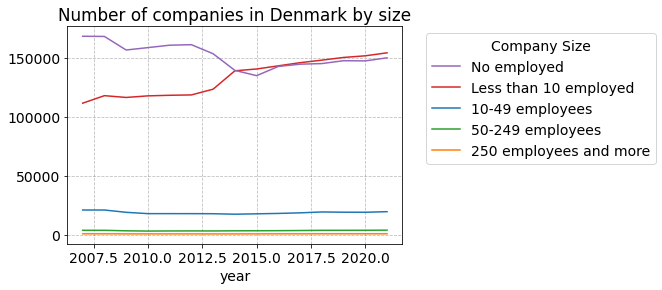

In [18]:
#We make a plot of companies of different sizes over the period.
#note, we remove 'Total, all enterprises' to make it easier to see changes over the years for individual company sizes.

ax = (gf02_size_reduced[gf02_size_reduced['size'] != 'Total, all enterprises'].reset_index()
    .pivot(index='year', columns='size', values='companies')
    .plot(title='Number of companies in Denmark by size'))

handles, labels = ax.get_legend_handles_labels()
# Here we specify the desired order for the legend labels
order_legend_size = ['No employed', 'Less than 10 employed', '10-49 employees', '50-249 employees', '250 employees and more']

# We create a new list of handles and labels in the desired order
handles_size = [handles[labels.index(label)] for label in order_legend_size]
labels_size = order_legend_size

plt.legend(title='Company Size', handles=handles_size, labels=labels_size, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Key takeaway:** 
* From the table we see that the total number of companies in Denmark for the period 2007-21 is between a low of approx 296.000 (2009) and a high of approx 328.500 (2021). The number of companies fell after the financial crisis in 2008-09 and stayed at a low level after it started increasing from around 2015.
* Not surprisingly the there are generally fewer medium-sized and big companies overall.
* All company-size groups have seen a drop after the financial crisis. However, the drop has been minor and briefly for the companies with less than 10 employed. On the other hand, the group of no employed has seen a drop until 2015. This can suggest, that some of the founders have chosen to close their business and take a job elsewhere. However, the growing number of companies with less than 10 employed, can also suggest that some of the companies with only the founder have succeeded in growing and hireing new employees, thus raising themselves from the 'No employed' category to the 'Less than 10 employed'.

To get a better understanding of the individual company-sizes we can make an interactive plot using widgets:

In [19]:
def plot_gf02_size(df, size): 
    I = df['size'] == size
    ax=df.loc[I,:].plot(x='year', y='companies', style='-o', legend=False)

In [20]:
widgets.interact(plot_gf02_size, 
    df = widgets.fixed(gf02_size),
    size = widgets.Dropdown(description='Size', 
                            options=gf02_size['size'].unique(), 
                            value='Total, all enterprises')
);

interactive(children=(Dropdown(description='Size', index=5, options=('No employed', 'Less than 10 employed', '…

**Key takeaway:** 
* Looking through the different size groups we see, that for the most part, there has been a tendency to an increasing number of companies from around 2014-15 and onwards. This suggests 1: more companies have been started around that time, and 2: companies already excisting have been able to hire more employees and grow to a larger company-size.
* The effects of the financial crisis becomes more evident looking at the groups individually, and thus, also how the 'Less than 10 employed' have been hit very mildly compared to the others.

We now want to do the same looking at companies in different industries using the subdataset gf02_industries constructed for the purpose. Again we create a wide dataset to get a table that is easier to read and then we plot the number of companies over the period for the industries.

In [21]:
#Same approach as for gf02_size
gf02_industries_wide = pd.pivot(gf02_industries_reduced, index='industry', columns='year', values='companies')
gf02_industries_wide = gf02_industries_wide.reindex(['1 Agriculture, forestry and fishing', 
                                         '2 Manufacturing, mining and quarrying, and utility services', 
                                         '3 Construction', 
                                         '4 Trade and transport etc.', 
                                         '5 Information and communication', 
                                         '6 Financial and insurance',
                                         '7 Real estate',
                                         '8 Other business services',
                                         '9 Public administration, education and health',
                                         '10 Arts, entertainment and other services',
                                         '11 Activity not stated',
                                         'TOT Industry total'])
gf02_industries_wide

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
industry,,,,,,,,,,,,,,,
"1 Agriculture, forestry and fishing",40453,38178,35176,34143,32705,32571,30722,29631,27618,27411,26185,26217,25835,25944,25428
"2 Manufacturing, mining and quarrying, and utility services",20814,20986,20349,20155,20312,20228,19667,19584,19341,19610,19698,19747,19840,19629,19636
3 Construction,35547,36024,33135,31588,31575,31300,30707,31280,31197,31973,32643,33306,33937,34756,35949
4 Trade and transport etc.,76256,74640,70950,71035,70428,69508,67656,66781,65635,66816,67559,67121,67149,66412,67232
5 Information and communication,11384,12217,12388,13597,14588,14962,15409,16109,16109,17130,17992,18492,18970,19003,19448
6 Financial and insurance,7720,10948,8602,9336,8983,9169,9301,10050,10943,12045,12818,13600,14141,14486,15224
7 Real estate,26176,26842,24489,24664,27220,27398,27574,27464,26935,28448,29216,29654,29644,30296,30935
8 Other business services,43195,44759,43267,45520,47637,48347,48810,50021,50038,53054,54721,55923,57584,57904,59768
"9 Public administration, education and health",23792,25064,26273,25653,24272,24676,25257,25039,25495,26495,26887,26992,27669,28139,28538


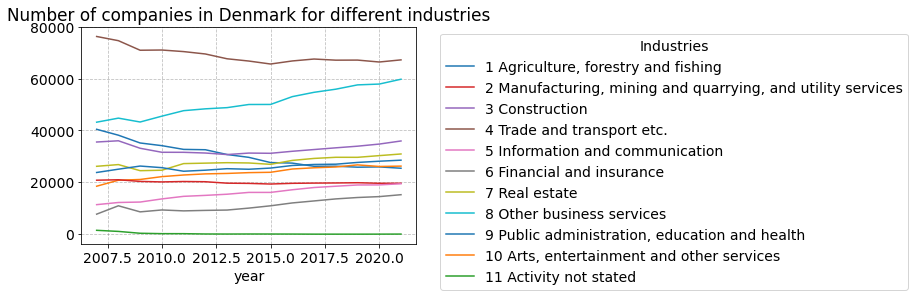

In [22]:
#We again make a plot, where we remove the total, so the plot is easier to "read".
ax = (gf02_industries_reduced[gf02_industries_reduced['industry'] != 'TOT Industry total'].reset_index()
    .pivot(index='year', columns='industry', values='companies')
    .plot(title='Number of companies in Denmark for different industries'))

handles, labels = ax.get_legend_handles_labels()
# Here we specify the desired order for the legend labels
order_legend_industries = ['1 Agriculture, forestry and fishing', 
                           '2 Manufacturing, mining and quarrying, and utility services', 
                           '3 Construction', 
                           '4 Trade and transport etc.', 
                           '5 Information and communication', 
                           '6 Financial and insurance',
                           '7 Real estate',
                           '8 Other business services',
                           '9 Public administration, education and health',
                           '10 Arts, entertainment and other services',
                           '11 Activity not stated']

# We create a new list of handles and labels in the desired order
handles_industries = [handles[labels.index(label)] for label in order_legend_industries]
labels_industries = order_legend_industries

plt.legend(title='Industries', handles=handles_industries, labels=labels_industries, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Key takeaway:** 
* From the table and the plot we see, that the trade and transport industry has the most companies in Denmark while the smallest number of companies are within financial and insurance (not including those where industry is not stated).
* There seems to have been a negative trend in the number of trade and transporting companies in general since 2007 which can suggest less activity in that industry in general or that fewer can do what previously took more companies.
* We see a similar trend in argiculture, forestry and fishing, which, given production is the same, can suggest that 1: fewer companies can produce the same (increasing productivity) or 2: larger companies operate larger amounts of land, forrest or fishing quotas.
* Not surprisingly we see a drop in construction companies after the financial crisis as we could expect from postponed building projects until better economic times (or increased government spending on infrastructure etc.).
* Only 'Information and communication' and 'Arts, entertainment and other services' seems to have been unaffected by the financial crisis in 2008-09 when looking at the number of companies. For IT this could be explained by the continuous trend of the economy and industries in general becoming more technological or low costs to start a business in that industry.


### 3.2. <a id='toc3_2_'></a>[Dataset DEMO4 - start-ups and bankruptcies over time and for different industries](#toc0_)

#### **Importing and displaying the dataset**

The business demography statistics (DEMO4) are an annual assessment of the number of genuinely new and genuinely ceased companies, as well as the number of full-time employees and turnover. The statistics are divided by industry, ownership type, and geographical location. The statistics are communicated in News from Statistics Denmark and in the statistics bank.

In the next section of this assignment we apply the same approach as described with the previous dataset (GF02) to import and clean the data.


In [23]:
from dataproject_copys import *
demo4_raw = import_demo4_data()

Table DEMO4: Business Demography by region, industry (DB07 10-grouping), unit and time
Last update: 2023-05-16T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,REGION,6,000,All Denmark,081,Region Nordjylland,False
1,BRANCHEDB0710,12,TOT,TOT Industry total,11,11 Activity not stated,False
2,MÆNGDE4,5,AFU,Employees (in full-time persons),NYE,New enterprises (number),False
3,Tid,15,2007,2007,2021,2021,True


REGION:


,id,text
0,000,All Denmark
1,084,Region Hovedstaden
2,085,Region Sjælland
3,083,Region Syddanmark
4,082,Region Midtjylland
5,081,Region Nordjylland


BRANCHEDB0710:


,id,text
0,TOT,TOT Industry total
1,1,"1 Agriculture, forestry and fishing"
2,2,"2 Manufacturing, mining and quarrying, and uti..."
3,3,3 Construction
4,4,4 Trade and transport etc.
5,5,5 Information and communication
6,6,6 Financial and insurance
7,7,7 Real estate
8,8,8 Other business services
9,9,"9 Public administration, education and health"


MÆNGDE4:


,id,text
0,AFU,Employees (in full-time persons)
1,OPH,Terminated enterprises (number)
2,OMS1,Turnover (DKK 1000)
3,EKS1,Export (DKK 1000)
4,NYE,New enterprises (number)


Tid:


,id,text
0,2007,2007
1,2008,2008
2,2009,2009
3,2010,2010
4,2011,2011
5,2012,2012
6,2013,2013
7,2014,2014
8,2015,2015
9,2016,2016


In [24]:
demo4_raw.head(5)

,REGION,BRANCHEDB0710,MÆNGDE4,TID,INDHOLD
0,Region Hovedstaden,8 Other business services,Terminated enterprises (number),2019,3589
1,Region Hovedstaden,"9 Public administration, education and health",Employees (in full-time persons),2019,296
2,Region Hovedstaden,"9 Public administration, education and health",Export (DKK 1000),2019,..
3,Region Hovedstaden,"9 Public administration, education and health",New enterprises (number),2019,1172
4,Region Hovedstaden,"9 Public administration, education and health",Turnover (DKK 1000),2019,415266


#### **Cleaning and renaming the dataset**

In [25]:
# Cleaning the data
demo4_clean = clean_demo4_data(demo4_raw)

Cleaning has been done successfully.


In [26]:
# Displaying the cleaned data
demo4_clean.head(5)

,industry,x,year,total
0,TOT Industry total,Employees (in full-time persons),2019,9078
1,TOT Industry total,Export (DKK 1000),2019,..
2,TOT Industry total,New enterprises (number),2019,33930
3,TOT Industry total,Turnover (DKK 1000),2019,23180665
4,TOT Industry total,Terminated enterprises (number),2019,31297


#### **Exploring the dataset**

In data analysis and visualization, it is common to encounter datasets organized in long or wide formats. Long format data typically features a single column for each variable and multiple rows representing different observations. Conversely, wide format data often organizes variables into separate columns, with each row representing a single observation.

Converting a dataset from long to wide format can be beneficial for various analytical tasks. One primary reason is to facilitate clearer and more concise data representation. By pivoting the data from long to wide format, we can often achieve a more intuitive layout, making it easier to comprehend relationships between variables.

In DENP4 we have 5 variables which we want to study their trends over the time period. By organizing the data in wide format allows us to visually inspect the changes in each variable more efficiently and this is done in the following section of this assignment.

In [27]:
demo4_wide = demo4_clean.pivot(index='x', columns='year', values='total')
demo4_wide

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
x,,,,,,,,,,,,,,,
Employees (in full-time persons),16081,11856,8786,9213,9858,8679,9386,9719,9523,8426,8324,8041,9078,9411,10025
Export (DKK 1000),2951529,3027391,2590263,1874870,..,..,..,..,..,..,..,..,..,..,..
New enterprises (number),36660,37197,27024,30799,33659,30696,28998,31089,29911,34116,33839,33295,33930,34779,35679
Terminated enterprises (number),31768,42386,37653,32278,30719,31775,31994,30989,32949,27476,30523,31294,31297,33159,37492
Turnover (DKK 1000),47073838,45228939,23798453,23151134,27691573,30122204,30389184,24049108,24637820,23556132,22395684,21440497,23180665,31893845,29600351


In [28]:
print(demo4_clean.dtypes)

industry    object
x           object
year         int64
total       object
dtype: object


As observed in the provided code above, the "total" parameter is identified as an object, rather than a numerical value. This occurs due to the presence of non-numeric entries, such as '..', within the export variable's numerical column and this needs to be fixed before moving on with the analysis. To address this issue, we employ pd.to_numeric() with the errors='coerce' parameter, effectively transforming non-numeric values into NaN (Not a Number). Subsequently, one may opt to either eliminate or substitute NaN values according to specific requirements. Below is a concise code excerpt illustrating this process.

In [29]:
# Convert 'total' column to numeric type, coercing errors to NaN
demo4_clean['total'] = pd.to_numeric(demo4_clean['total'], errors='coerce')

# Check for NaN values after conversion
print(demo4_clean[demo4_clean['total'].isna()])

              industry                  x  year  total
1   TOT Industry total  Export (DKK 1000)  2019    NaN
8   TOT Industry total  Export (DKK 1000)  2013    NaN
11  TOT Industry total  Export (DKK 1000)  2016    NaN
18  TOT Industry total  Export (DKK 1000)  2014    NaN
21  TOT Industry total  Export (DKK 1000)  2021    NaN
28  TOT Industry total  Export (DKK 1000)  2012    NaN
33  TOT Industry total  Export (DKK 1000)  2015    NaN
36  TOT Industry total  Export (DKK 1000)  2020    NaN
41  TOT Industry total  Export (DKK 1000)  2018    NaN
53  TOT Industry total  Export (DKK 1000)  2011    NaN
71  TOT Industry total  Export (DKK 1000)  2017    NaN


In this phase of the assignment, we successfully imported the DEMO4 API and processed the dataset, addressing issues such as non-numeric values and ensuring data is cleaned up. With the dataset now cleaned and prepared, our next step involves merging it with the GF02 dataset. By combining these datasets, we aim to gain deeper insights and enrich our analysis. 

## 4. <a id='toc4_'></a>[Merging the datasets](#toc0_)

Both of the datasets have the industries in common. We therefore want to adapt them, so that we can merge them on industries. This will give us the number of companies for different industries from GF02 and the employees, export, new enterprises/companies, turnover and number of terminated enterprises/companies from DEMO4. For the further analysis we are especially interested in the number of new and the number of terminated enterprises/companies.

In [30]:
from dataproject_copys import merge_datasets
# Merging datasets
gf02_demo4_merged = merge_datasets(demo4_raw, gf02_industries_reduced)
display(gf02_demo4_merged)

,industry,year,companies,employees(fulltime),Export(DKK1000),Startups,Bankruptcies,Turnover(DKK1000)
0,"1 Agriculture, forestry and fishing",2007,40453,389,96064,2458,3917,2382060
1,"1 Agriculture, forestry and fishing",2008,38178,324,109968,2264,5001,2387493
2,"1 Agriculture, forestry and fishing",2009,35176,282,64249,1584,3936,1490702
3,"1 Agriculture, forestry and fishing",2010,34143,236,19883,1661,2885,1117631
4,"1 Agriculture, forestry and fishing",2011,32705,291,..,2220,2278,1453093
...,...,...,...,...,...,...,...,...
175,TOT Industry total,2017,313331,8324,..,33839,30523,22395684
176,TOT Industry total,2018,316970,8041,..,33295,31294,21440497
177,TOT Industry total,2019,321494,9078,..,33930,31297,23180665
178,TOT Industry total,2020,322695,9411,..,34779,33159,31893845


**Key takeaway:** As we have made the dataframes so similarly structured when sorted by industry and year, it does not make any difference in the merged dataframe above, gf02_demo4_merged, whether we use an outer, inner or left merge. In either case we have the variables from the one dataframe added to the other for a combined long dataset of 180 rows and 8 columns. Had we for instance not removed the firm-size, it could have made sense to do a different merge to keep data in either or both frames (outer merge), data that are only in both sets (inner merge) or data that are in the left or both datasets (left merge).

## 5. <a id='toc5_'></a>[Analysis](#toc0_)

#### **The GF02 data**

After having been inspecting gf02 on size of companies and industries, for the further analysis we have constructed a plot where we can condition on both size and industry, to further examine some of the previous findings. To do this, we use the gf02_all_rename rather than our merged dataset, as it contains number of firms depending on size and industry.

In [32]:
merged_plot(gf02_all_rename)

interactive(children=(Dropdown(description='Size', index=5, options=('No employed', 'Less than 10 employed', '…

In [ ]:
#We define a function, where we filter by size and industry, so we can construct a widget with two dropdowns below.
def plot_gf02_all_rename(df, size, industry): 
    filtered_df = df[(df['size'] == size) & (df['industry'] == industry)]
    ax=filtered_df.plot(x='year', y='companies', style='-o', legend=False)

In [ ]:
widgets.interact(plot_gf02_all_rename, 
    df = widgets.fixed(gf02_all_rename),
    industry=widgets.Dropdown(description='Industry', options=gf02_all_rename['industry'].unique(), value='1 Agriculture, forestry and fishing'),
    size = widgets.Dropdown(description='Size', options=gf02_all_rename['size'].unique(), value='Total, all enterprises')
);

**Key takeaway:** focusing on the findings from earlier, by clicking through combinations of size for selected industries we see:
* Accross all industries we see the same tendency for smaller companies (less than 10 employed or no employed) to make op the predominant amount of companies.
* Looking at Argiculture, forestry and fishing we see, that there are very few large companies. There is a tendency for more medium sized companies in this industry, however, for the most part, the negative trend for companies in this industry is due to a decrease in the small companies/owners since around the time of the financial crisis.
* Looking at construction we see, that there has been a downwards trend for company sizes until around 2012. Especially those with 10-49 employees have been slow, implying that going from less than 10 employees to 10-49 is cumbersome - the exact reason why is undisclosed in the data.
* For information and communication we see and overall tendency to an increasing number of companies, that is particularly driven by the smaller companies (no employed and less than 10). A fall for especially the larger companies from around the time of the financial crisis, could indicate a downscaling of employees to meet less demand from due to the economic downturn. 

#### **The DEMO4 data**

In this analysis, we delve into the DEMO4 dataset to explore the aggregate trends across five key variables: Employees (in full-time persons), Export (DKK 1000), New enterprises (number), Number of terminated enterprises, and Turnover (DKK 1000). 

To effectively visualize and analyze the total values of these variables over time, we employ an intuitive dropdown-plot approach as we did for the GF02 data above. The function plot_demo4_wide is designed to dynamically generate plots based on the selected variable ('x') from a dropdown menu. This functionality offers the option to explore each variable individually, gaining insights into how it evolves over different time periods.

In [ ]:
def plot_demo4_wide(df, x): 
    I = df['x'] == x
    ax = df.loc[I,:].sort_values('year').plot(x='year', y='total', style='-o', legend=False)


In [ ]:
widgets.interact(plot_demo4_wide, 
    df = widgets.fixed(demo4_clean),
    x = widgets.Dropdown(description='total', 
                            options=demo4_clean['x'].unique(), 
                            value='Employees (in full-time persons)')
);

**Key takeaway:** Upon analysis of the depicted figure, it is evident that the turnover, employee count, export volumes, and number of terminated companies exhibited a marked decline during the Financial Crisis of 2008, a trend that aligns with expectations. Moreover, there is a noticeable surge in the number of newly established companies commencing from 2015. This upsurge can be attributed to the resurgence of optimism within Danish society, marking the first instance of substantial economic confidence since the Financial Crisis of 2008. This resurgence was notably reported by Danish media outlet TV2 in 2015. The period from 2008 until the onset of the COVID-19 Crisis in 2020 witnessed the longest economic upswing in recent Danish history. This prolonged period of economic growth has facilitated numerous advantages for new firms, including enhanced accessibility to financial resources.

In the next part of the assignment, we will select variables a few of the 5 variables to investigate the survival rate and startup rate across various branches within Denmark.

#### **Examining the merged data**

The provided code segment serves to enhance the analytical capabilities of the DataFrame gf02_demo4_merged by converting relevant columns to numeric data type, calculating survival and startup rates, and displaying the resulting DataFrame.

First, the columns 'startups', 'bankruptcies', and 'companies' are converted to numeric data types as we did earlier.

Secoundly, the survival rate is calculated by dividing the number of startups by the number of bankruptcies. Similarly, the startup rate is computed by dividing the number of startups by the total number of companies, offering insights into the prevalence of new business ventures within the broader business landscape.

Finally, the resulting DataFrame, enriched with these calculated rates, is displayed, providing a comprehensive overview of the dataset's analytical enhancements and insights into the startup and survival dynamics within the merged dataset

In [ ]:
# Convert relevant columns to numeric data type
gf02_demo4_merged['startups'] = pd.to_numeric(gf02_demo4_merged['startups'], errors='coerce')
gf02_demo4_merged['Bankruptcies'] = pd.to_numeric(gf02_demo4_merged['Bankruptcies'], errors='coerce')
gf02_demo4_merged['companies'] = pd.to_numeric(gf02_demo4_merged['companies'], errors='coerce')

# Calculate survival rate
gf02_demo4_merged['survival_rate'] = gf02_demo4_merged['startups'] / gf02_demo4_merged['Bankruptcies']

# Calculate startup rate
gf02_demo4_merged['startup_rate'] = gf02_demo4_merged['startups'] / gf02_demo4_merged['companies']

# Display the DataFrame
gf02_demo4_merged

The following code will generate a figure which can be used to analyze the survival and startup rates across diverse industries in Denmark. We define a list of key sectors and assign colors for visualization. Subplots are created to display average survival and startup rates from 2007 to 2021 for each industry.

In [ ]:
# We have removed '11 Activity not stated'
industries_of_interest = ['1 Agriculture, forestry and fishing', 
                          '2 Manufacturing, mining and quarrying, and utility services', 
                          '3 Construction', 
                          '4 Trade and transport etc.', 
                          '5 Information and communication', 
                          '6 Financial and insurance',
                          '7 Real estate',
                          '8 Other business services',
                          '9 Public administration, education and health',
                          '10 Arts, entertainment and other services',
                          'TOT Industry total']

# Define colors for each industry
colors = ['Blue', 'Orange', 'Green', 'Red', 'Purple', 'Brown', 'Pink', 'Gray', 'Olive', 'Cyan', 'Black']

# Create subplots for survival rate and startup rate
fig, axes = plt.subplots(1, 2, figsize=(20,5))

# Plot average survival rate
plt.subplot(1, 2, 1)
for i, industry in enumerate(industries_of_interest):
    avg_survival_rate = gf02_demo4_merged[gf02_demo4_merged['industry'] == industry]['survival_rate'].mean()
    plt.bar(i, avg_survival_rate, color=colors[i], label=industry, alpha=0.7)
plt.xlabel('Industry')
plt.ylabel('Average Survival Rate')
plt.title('Average Survival Rate (2007-2021)')
plt.gca().set_xticklabels([])

# Plot average startup rate
plt.subplot(1, 2, 2)
for i, industry in enumerate(industries_of_interest):
    avg_startup_rate = gf02_demo4_merged[gf02_demo4_merged['industry'] == industry]['startup_rate'].mean()
    plt.bar(i, avg_startup_rate, color=colors[i], label=industry, alpha=0.7)
plt.xlabel('Industry')
plt.ylabel('Average Startup Rate')
plt.title('Average Startup Rate (2007-2021)')
plt.gca().set_xticklabels([])

# Add a common legend
plt.legend(title='Industry', bbox_to_anchor=(1.7, 1), loc='upper left', borderaxespad=0., fontsize='small')

plt.tight_layout()
plt.show()


**Key takeaway:**
* As illustrated in the figure above, the agricultural sector exhibits a survival rate below the threshold of 1, indicating a prevalence of bankruptcies exceeding the establishment of new enterprises within this domain. Furthermore, the agricultural sector demonstrates the lowest startup rate among all branches, approximately ranging between 5-6% as depicted in the figure. This phenomenon may be attributed to the formidable entry barriers characteristic of this sector. For instance, embarking on agricultural endeavors, such as pork meat farming, necessitates access to substantial financial resources, given the exorbitant costs associated with stables, machinery, livestock, land and customized equipment tailored to specific stable requirements.
* In contrast to the agricultural sector, the "Information and communication" industry exhibits a survival rate surpassing the threshold of 1, suggesting a prevalence of sustainable ventures outweighing the incidence of business closures within this domain. Moreover, this sector boasts the highest startup rate among all branches, estimated at approximately 17%. This notable trend could be attributed to the relatively low entry barriers prevalent in this market segment. In many cases, initiating endeavors within the "Information and communication" industry merely requires minimal resources, such as a phone and a computer. Such accessibility facilitates the establishment of new ventures and fosters a dynamic entrepreneurial landscape within this sector.

The real estate sector is incorporated alongside Information and Communication and Agriculture for next part of the analysis. This decision is motivated by the anticipation of substantial changes, particularly during the 2008 financial crisis, within these specific industries.

#### **Development in startups**

In [ ]:
selected_industries = ['1 Agriculture, forestry and fishing', 
                       '5 Information and communication', 
                       '7 Real estate']
filtered_df = gf02_demo4_merged[gf02_demo4_merged['industry'].isin(selected_industries)]

ax = (filtered_df.reset_index()
      .pivot(index='year', columns='industry', values='startups')
      .plot(title='Number of startups in Denmark for selected industries'))

handles, labels = ax.get_legend_handles_labels()
order_legend_industries = selected_industries

handles_industries = [handles[labels.index(label)] for label in order_legend_industries]
labels_industries = order_legend_industries

plt.legend(title='Industries', handles=handles_industries, labels=labels_industries, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Key takeaway:**
In the analysis presented above, it is evident that the real estate and agriculture sectors were significantly impacted by the 2008 financial crisis. This outcome was anticipated, given the marked downturn in housing purchases during this period and the challenges faced by Danish farmers in acquiring the necessary capital to overcome the sector's high entry barriers, such as purchasing land, stables, and livestock. Conversely, the information and communication industry demonstrated resilience during the crisis by successfully attracting new entrants to the market.

From 2015 onwards, all three sectors observed a notable influx of new market participants. This trend can be attributed to the resurgence of optimism within Danish society and the initiation of the longest economic upturn in Denmark's recent history, as previously discussed. This extended phase of economic prosperity has provided new enterprises with significant benefits, including improved access to financial resources.

Below, we will continue the comparative analysis of the three industries, examining the number of companies within each sector and their respective developmental trajectories over the examined period.

In [ ]:
selected_industries = ['1 Agriculture, forestry and fishing', 
                       '5 Information and communication', 
                       '7 Real estate']
filtered_df = gf02_demo4_merged[gf02_demo4_merged['industry'].isin(selected_industries)]

ax = (filtered_df.reset_index()
      .pivot(index='year', columns='industry', values='companies')
      .plot(title='Number of companies in Denmark for selected industries'))

handles, labels = ax.get_legend_handles_labels()
order_legend_industries = selected_industries

handles_industries = [handles[labels.index(label)] for label in order_legend_industries]
labels_industries = order_legend_industries

plt.legend(title='Industries', handles=handles_industries, labels=labels_industries, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Key takeaway:** 
* The agricultural sector is experiencing a consolidation trend, with a noticeable shift from numerous small entities towards fewer, larger corporations. This trend likely stems from the strategic pursuit of economies of scale, increasingly significant in this sector, thereby raising the barriers to entry even further.
* The real estate sector witnessed a temporary decline in company numbers following the 2008 financial crisis, succeeded by a consistent upward trajectory. This recovery aligns with the prolonged economic resurgence in Danish society, the longest in recent memory, underpinning a robust housing market historically.
* The observable growth within the Information and Communication sector is presumably linked to the widespread digital transformation across all industries, reflecting a significant shift towards digitalization.

## 6. <a id='toc6_'></a>[Concluding remarks](#toc0_)

The project aimed to delve into the composition of companies across various industries in Denmark, spanning the period from 2007 to 2021. Our objective was to discern the effects attributed to economic shifts, particularly stemming from events such as the 2008-2009 financial crisis. Additionally, we intended to examine the propensity for new company formations within different industries during this timeframe.

To accomplish these objectives, we leverage two primary datasets sourced from Statistics Denmark (Statistikbanken): GF02 and DEMO4. Utilizing the DstApi provided by Statistics Denmark, we access and extract data from these datasets. Subsequently, we embark on a comprehensive journey of data exploration, cleansing, and analysis to unravel insights encapsulated within these datasets.

In the introduction to the project, we laid out a series of questions that we intend to explore, and we have addressed these queries throughout the project, covering them in the different sections.